In [1]:
import pandas as pd
import mdtraj as md
import numpy as np
from numpy.random import seed
from numpy.random import shuffle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from __future__ import print_function
import seaborn as sns
from matplotlib.ticker import NullFormatter, MaxNLocator
from pandas.plotting import scatter_matrix
import matplotlib.ticker as ticker
import plotly.graph_objects as go
import scipy as sp
from itertools import chain
import matplotlib as mpl
from matplotlib.lines import Line2D
from scipy import spatial
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
import scipy.stats as stats
import statsmodels.stats.weightstats
from matplotlib import path
import matplotlib
from scipy.stats import probplot,shapiro, sem
import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

from scipy import stats
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,r2_score, mean_squared_error
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.linear_model import RidgeCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler

from matplotlib import cm
from numpy import linspace
import umap.umap_ as umap
#import pylab
import os
#import PIL
from scipy.ndimage import gaussian_filter, uniform_filter1d

# Some Functions

In [2]:
def RSA_based_fC(protein_var,protein_name,poly_id,
                       GW_moment_var,every_ith_snap,GW_every_ith_snap,radius_):
    x_total=[]
    y_total=[]
    if poly_id=='protein':
        protein_label=protein_name
        temp_protein=protein_var.copy()
        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)
        x_total=list(chain.from_iterable(x_total))
        y_total=list(chain.from_iterable(y_total))
        poly_var=protein_var.copy()
        protein_pro=poly_var[['ratio','RSA']].iloc[:every_ith_snap,:].copy()
        protein_pro['polymer_id']=np.repeat(protein_label,protein_pro.shape[0])
        del x_total, y_total, temp_protein

    elif poly_id=='polymer':
        print('protein_var MUST be single epas')
        protein_label=protein_name
        temp_protein=protein_var.copy()
        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)
        x_total=list(chain.from_iterable(x_total))
        y_total=list(chain.from_iterable(y_total))
        poly_var=protein_var.copy()
        protein_pro=poly_var[['ratio','RSA']].iloc[:every_ith_snap,:].copy()
        protein_pro['polymer_id']=np.repeat(protein_label,protein_pro.shape[0])
        del x_total, y_total, temp_protein
    
    
    elif poly_id=='pei':
        print('protein_var MUST be single proton state')
        protein_label='pei_'+ str(protein_name)
        temp_protein=protein_var.copy() # temp_protein isn't really needed but just adding
        poly_var=protein_var.copy()
        protein_pro=poly_var[['ratio','RSA']].iloc[:every_ith_snap,:].copy()
        protein_pro['polymer_id']=np.repeat(protein_label,protein_pro.shape[0])
        del x_total, y_total, temp_protein
    else:
        return print('ERROR')
    
    
    GW_po=GW_moment_var[['ratio','RSA']][::GW_every_ith_snap].copy()
    GW_po['polymer_id']=np.repeat('GW',GW_po.shape[0])
    
    #calculate mean and stdev values (must keep same mean and stdev values)
    upto_snapshots=1000000
    GW_mean_ratio=np.mean(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_std_ratio=np.std(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_mean_RSA=np.mean(GW_po['RSA'].values[0:(upto_snapshots+1)])
    GW_std_RSA=np.std(GW_po['RSA'].values[0:(upto_snapshots+1)])
        
    combined_pro_po=pd.concat([GW_po,protein_pro],axis=0,ignore_index=True)
    combined_pro_po['stdd_ratio']=(combined_pro_po['ratio'].values-GW_mean_ratio)/(GW_std_ratio)
    combined_pro_po['stdd_RSA']=(combined_pro_po['RSA'].values-GW_mean_RSA)/(GW_std_RSA)
    po_x=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_RSA'].values
    po_y=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_ratio'].values
    pro_x=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_RSA'].values
    pro_y=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_ratio'].values
    
    GW_points=np.c_[po_x, po_y]
    protein_points=np.c_[pro_x, pro_y]    
    tree_GW=spatial.cKDTree(GW_points)
    tree_protein=spatial.cKDTree(protein_points)

    GW_not_in_range=[]
    j=0
    for point in GW_points:

        if not tree_protein.query_ball_point(point,radius_):
            GW_not_in_range.append(point)
        j+=1
        if j%500000==0:
            print(f'{j} GW snapshots completed')
                
    fC_by_distance=(GW_points.shape[0]-len(GW_not_in_range))/(GW_points.shape[0])
    return fC_by_distance    


In [3]:
def RSA_Rs_protein_3dplot_against_GW(protein_var,protein_label,second_obj,provided_color):
    
    x_variable= 'RSA'
    y_variable=r'$R_s$'
    global fC_value, grid_protein, grid_GW

    testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
    
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams["axes.labelweight"] = "regular"
    
    
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]


    x_polmodel_GW.append(testeq_GW['RSA'].values)
    y_polmodel_GW.append(testeq_GW['ratio'].values)

    if second_obj=='protein':        
        temp_protein =  protein_var.copy()

        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)

        fC_value=RSA_based_fC(temp_protein,
                       protein_label,
                       second_obj,testeq_GW,
                       temp_protein.shape[0],
                       1,0.1)            
        del temp_protein
    else:
        print('ERROR. FIX ERROR')

    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    # Set up default x and y limits
    max_x_val=1
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    if testeq_GW['RSA'].max()>max_x_val or testeq_GW['RSA'].min()<0:
        return print('ERROR')
    elif max(x_total)>max_x_val or min(x_total)<0:
        return print('ERROR')        
    elif testeq_GW['ratio'].max()>max_y_val or testeq_GW['ratio'].min()<0:
        return print('ERROR')
    elif max(y_total)>max_y_val or min(y_total)<0:
        return print('ERROR')        

    # Set up your x and y labels
    xlabel = x_variable
    ylabel = y_variable

    # Define the locations for the axes

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram


    # Set up the size of the figure
    fig = plt.figure(1, figsize=(5.2,5))

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram


    axHistx.axes.get_xaxis().set_visible(False)
    axHisty.axes.get_yaxis().set_visible(False)


    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    #
    # Define the number of bins
    nxbins = 100
    nybins = 50
    nbins = nxbins+nybins

    xbins = linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)


    X = xcenter
    Y = ycenter

    axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                      marker=scatter_markers[3],s=1,alpha=0.6,color='black',
                       label='GW')
    
    axTemperature.scatter(x_total,
               y_total,
               marker=scatter_markers[0],s=1,alpha=0.6,color=provided_color,
                                      label=protein_label)                



    #Plot the axes labels
    axTemperature.set_xlabel(xlabel,fontsize=12,labelpad = 1)
    axTemperature.set_ylabel(ylabel,fontsize=12, labelpad = 1)

    #Set up the plot limits
    axTemperature.set_xlim(xlims)
    axTemperature.set_ylim(ylims)

    #Set up the histogram bins
    xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
    ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)


    axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',histtype='step',
                linewidth = 0.7,density=True)
    axHistx.hist(x_total, bins=xbins, color = provided_color,histtype='step',
                label=protein_label,linewidth = 0.7,density=True)

    axHisty.hist(y_polmodel_GW, bins=np.arange(min(y_total),max(y_total),1), color = 'black',orientation='horizontal',histtype='step',
                linewidth = 0.7,density=True)

    axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',histtype='step',
                label=protein_label,linewidth = 0.7,density=True)    
    
    #original_n_divisions=100
    step_x=0.02#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=0.6#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])

    axTemperature.text(0.7,0.8,
                       '$f_C$= '+format(fC_value,'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)
    axTemperature.text(0.7,0.74,
                       '$f_A$= '+format(np.count_nonzero(grid_protein)/np.count_nonzero(grid_GW),'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)    

    axTemp_legend=axTemperature.legend(fontsize=7,loc='upper right')

    frame = axTemp_legend.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    #axHisty.hist(y, bins=ybins, orientation='horizontal', color = provided_color)






    #Set up the histogram limits
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    axHistx.set_ylabel('Prob. Density',fontsize=12)
    axHisty.set_xlabel('Prob. Density',fontsize=12)


    #Cool trick that changes the number of tickmarks for the histogram axes
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(3))

    for i in ['top', 'left', 'right', 'bottom']:
        axHistx.spines[i].set_linewidth(1)
        axHisty.spines[i].set_linewidth(1)
        axTemperature.spines[i].set_linewidth(1)

    axHistx.minorticks_on()
    axHistx.tick_params(axis='y', which='major', labelsize=10, width = 0.8, pad = 2)
    axHistx.tick_params(axis='y', which='minor', width = 0.6)
    axHisty.minorticks_on()
    axHisty.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2,labelrotation=270)
    axHisty.tick_params(axis='x', which='minor', width = 0.6)
    axTemperature.minorticks_on()
    axTemperature.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad = 2)
    axTemperature.tick_params(axis='both', which='minor', width = 0.6)    
    plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
    plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
    #fig.subplots_adjust(hspace=0.85,wspace=0.85)

    # Save to a File
    filename = 'GW_3d_plot'
    #plt.savefig(f'figures/GW_{protein_label}_3dplot.png', dpi = 1000, bbox_inches='tight')
    return 



In [4]:
def protein_3dplot_against_GW(protein_var,protein_label,second_obj,provided_color):
    
    x_variable= r'$R_g\left/R_g^{theta}\right.$' 
    y_variable=r'$R_s$'
    global grid_protein, grid_GW

    testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
    
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams["axes.labelweight"] = "regular"
    
    
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]

    GW_rg = testeq_GW['Rg2']**0.5
    GW_rg_mean = GW_rg.mean()
    GW_rg_by_rg_mean = GW_rg/GW_rg_mean
    testeq_GW['Rg/Rg_mean'] = GW_rg_by_rg_mean
    
    x_polmodel_GW.append(GW_rg_by_rg_mean)
    y_polmodel_GW.append(testeq_GW['ratio'].values)
    
    if second_obj=='protein':        
        temp_protein =  protein_var.copy()

        x_total.append(temp_protein['Rg/Rg_theta'].values)
        y_total.append(temp_protein.ratio.values)

        # fC_value=RSA_based_fC(temp_protein,
        #                protein_label,
        #                second_obj,testeq_GW,
        #                temp_protein.shape[0],
        #                1,0.1)            
        del temp_protein
    else:
        print('ERROR. FIX ERROR')

    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    # Set up default x and y limits
    max_x_val=5
    max_y_val=35
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    if testeq_GW['Rg/Rg_mean'].max()>max_x_val or testeq_GW['Rg/Rg_mean'].min()<0:
        return print('ERROR')
    elif max(x_total)>max_x_val or min(x_total)<0:
        return print('ERROR')        
    elif testeq_GW['ratio'].max()>max_y_val or testeq_GW['ratio'].min()<0:
        return print('ERROR')
    elif max(y_total)>max_y_val or min(y_total)<0:
        return print('ERROR')        

    # Set up your x and y labels
    xlabel = x_variable
    ylabel = y_variable

    # Define the locations for the axes

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram


    # Set up the size of the figure
    fig = plt.figure(1, figsize=(5.2,5))

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram


    axHistx.axes.get_xaxis().set_visible(False)
    axHisty.axes.get_yaxis().set_visible(False)


    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    #
    # Define the number of bins
    nxbins = 100
    nybins = 50
    nbins = nxbins+nybins

    xbins = linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)


    X = xcenter
    Y = ycenter

    axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                      marker=scatter_markers[3],s=1,alpha=0.6,color='black',
                       label='GW')
    
    axTemperature.scatter(x_total,
               y_total,
               marker=scatter_markers[0],s=1,alpha=0.6,color=provided_color,
                                      label=protein_label)                



    #Plot the axes labels
    axTemperature.set_xlabel(xlabel,fontsize=12,labelpad = 1)
    axTemperature.set_ylabel(ylabel,fontsize=12, labelpad = 1)

    #Set up the plot limits
    axTemperature.set_xlim(xlims)
    axTemperature.set_ylim(ylims)

    #Set up the histogram bins
    xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
    ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)


    axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',histtype='step',
                linewidth = 0.7,density=True)
    axHistx.hist(x_total, bins=xbins, color = provided_color,histtype='step',
                label=protein_label,linewidth = 0.7,density=True)

    axHisty.hist(y_polmodel_GW, bins=np.arange(min(y_total),max(y_total),1), color = 'black',orientation='horizontal',histtype='step',
                linewidth = 0.7,density=True)

    axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',histtype='step',
                label=protein_label,linewidth = 0.7,density=True)    
    
    #original_n_divisions=100
    step_x=0.02#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=0.6#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])

    # axTemperature.text(0.7,0.8,
    #                    '$f_C$= '+format(fC_value,'0.3f'),
    #                   transform=axTemperature.transAxes,fontsize=8)
    axTemperature.text(0.7,0.74,
                       '$f_A$= '+format(np.count_nonzero(grid_protein)/np.count_nonzero(grid_GW),'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)    

    axTemp_legend=axTemperature.legend(fontsize=7,loc='upper right')

    frame = axTemp_legend.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    #axHisty.hist(y, bins=ybins, orientation='horizontal', color = provided_color)






    #Set up the histogram limits
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    axHistx.set_ylabel('Prob. Density',fontsize=12)
    axHisty.set_xlabel('Prob. Density',fontsize=12)


    #Cool trick that changes the number of tickmarks for the histogram axes
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(3))

    for i in ['top', 'left', 'right', 'bottom']:
        axHistx.spines[i].set_linewidth(1)
        axHisty.spines[i].set_linewidth(1)
        axTemperature.spines[i].set_linewidth(1)

    axHistx.minorticks_on()
    axHistx.tick_params(axis='y', which='major', labelsize=10, width = 0.8, pad = 2)
    axHistx.tick_params(axis='y', which='minor', width = 0.6)
    axHisty.minorticks_on()
    axHisty.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2,labelrotation=270)
    axHisty.tick_params(axis='x', which='minor', width = 0.6)
    axTemperature.minorticks_on()
    axTemperature.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad = 2)
    axTemperature.tick_params(axis='both', which='minor', width = 0.6)    
    plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
    plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
    #fig.subplots_adjust(hspace=0.85,wspace=0.85)

    # Save to a File
    filename = 'GW_3d_plot'
    #plt.savefig(f'figures/GW_{protein_label}_3dplot.png', dpi = 1000, bbox_inches='tight')
    return 



# generate a dataframe connecting directory with seq_name in their property df

In [5]:
seq_name_AFRC = pd.read_csv('../holehouse_project/IDRome_shape_mean_size_mean_added.csv')

In [6]:
%%time
seq_name_list = []
seq_name_dir = []
protein_name = []
for root, dirs, files in os.walk('IDROME_larsen/IDRome_v4/', topdown=False):
    for name in files:
        seq_name_list.append(''.join(root.split('/')[2:(len(root.split('/'))-1)]+['_']+[root.split('/')[len(root.split('/'))-1]]))
        protein_name.append(''.join(root.split('/')[2:(len(root.split('/'))-1)]))
        seq_name_dir.append(root)
        break
seq_name_dir_df = pd.DataFrame(zip(seq_name_list,seq_name_dir,protein_name),columns=['seq_name','seq_dir','protein_uniprot_id'])
del seq_name_list, seq_name_dir, protein_name
seq_name_dir_df

CPU times: user 293 ms, sys: 1.24 s, total: 1.53 s
Wall time: 15.5 s


,seq_name,seq_dir,protein_uniprot_id
0,H0YL14_1_46,IDROME_larsen/IDRome_v4/H0/YL/14/1_46,H0YL14
1,H0YL09_1_131,IDROME_larsen/IDRome_v4/H0/YL/09/1_131,H0YL09
2,H0YKK7_1_89,IDROME_larsen/IDRome_v4/H0/YK/K7/1_89,H0YKK7
3,H0YKK7_135_164,IDROME_larsen/IDRome_v4/H0/YK/K7/135_164,H0YKK7
4,H0YKK7_430_550,IDROME_larsen/IDRome_v4/H0/YK/K7/430_550,H0YKK7
...,...,...,...
28053,A3QJZ6_111_153,IDROME_larsen/IDRome_v4/A3/QJ/Z6/111_153,A3QJZ6
28054,A3QJZ7_106_152,IDROME_larsen/IDRome_v4/A3/QJ/Z7/106_152,A3QJZ7
28055,A3KN83_1001_1044,IDROME_larsen/IDRome_v4/A3/KN/83/1001_1044,A3KN83
28056,A3KN83_1_250,IDROME_larsen/IDRome_v4/A3/KN/83/1_250,A3KN83


In [7]:
# gather RW data containing three eigenvalues
RW_data = pd.read_csv('../random_walk/with_RSA/RW_chain_length_100/RW_for_RSA_100_master_out.csv')
RW_data['Rend2']=RW_data.rendx2+RW_data.rendy2+RW_data.rendz2
RW_data['Rg2']=RW_data.rgx2+RW_data.rgy2+RW_data.rgz2
RW_data['ratio']=RW_data.Rend2.values/RW_data.Rg2.values
RW_data['asphericity']=RW_data.rg1.values-(0.5*(RW_data.rg2.values+RW_data.rg3.values))
RW_data['acylindricity']=RW_data.rg2.values-RW_data.rg3.values
RW_data['RSA']=(RW_data.asphericity.values**2+(0.75*RW_data.acylindricity.values**2))/(RW_data.rg1.values+RW_data.rg2.values+RW_data.rg3.values)**2

#drop first 10% of frames from EACH run and then get new RW df

j=0
for run in RW_data.run_number.unique():
    frames_number=len(RW_data[RW_data.run_number==run].index)
    equil_frames=int(0.90*frames_number)
    temp_df = RW_data[RW_data.run_number==run].iloc[-equil_frames:,:].reset_index()
    if j==0:
        blank_df = temp_df.copy()
    elif j>0:
        blank_df = pd.concat([blank_df,temp_df],axis=0).copy()
    j+=1
equil_test=blank_df.copy()
equil_test=equil_test.drop(['frames','econf'],axis=1).reset_index()
RW_equil = equil_test.copy()

del blank_df, temp_df,  equil_test, RW_data


In [8]:
os.listdir('../SAW/with_RSA/')

['SAW_RW_for_IDPstudy', 'SAW_chain_length_100']

In [9]:
SAW_data = pd.read_csv('../SAW/with_RSA/SAW_chain_length_100/SAW_for_RSA_100_master_out.csv')
SAW_data

,frames,run_number,epas,chain_length,econf,rgx2,rgy2,rgz2,rendx2,rendy2,rendz2,rg3,rg2,rg1
0,25000,1,0.00,100,0.00,2.7619,40.1984,32.8971,16.0,441.0,324.0,1.863053,6.554163,67.440183
1,50000,1,0.00,100,0.00,7.5251,42.1796,6.9571,81.0,361.0,1.0,1.757687,5.424012,49.480101
2,75000,1,0.00,100,0.00,11.9571,8.1700,25.8491,4.0,64.0,225.0,1.808933,12.789237,31.378029
3,100000,1,0.00,100,0.00,18.5424,4.3739,10.3475,256.0,36.0,1.0,2.261334,9.486018,21.516448
4,125000,1,0.00,100,0.00,3.0411,13.6964,16.7771,4.0,81.0,36.0,2.518413,10.726047,20.270141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500295,1250150000,10,0.16,100,54.40,20.5116,2.0600,9.5000,144.0,1.0,100.0,1.204367,4.750700,26.116534
1500296,1250175000,10,0.16,100,50.56,15.9699,9.1891,9.5764,100.0,9.0,100.0,0.904990,2.822060,31.008349
1500297,1250200000,10,0.16,100,46.72,2.7139,4.5139,11.3164,4.0,1.0,144.0,2.281002,3.114463,13.148734
1500298,1250225000,10,0.16,100,49.92,6.3504,8.5699,2.1971,81.0,36.0,0.0,1.407813,1.903827,13.805759


In [10]:
# gather SAW data containing three eigenvalues
SAW_data = pd.read_csv('../SAW/with_RSA/SAW_chain_length_100/SAW_for_RSA_100_master_out.csv')
SAW_data['Rend2']=SAW_data.rendx2+SAW_data.rendy2+SAW_data.rendz2
SAW_data['Rg2']=SAW_data.rgx2+SAW_data.rgy2+SAW_data.rgz2
SAW_data['ratio']=SAW_data.Rend2.values/SAW_data.Rg2.values
SAW_data['asphericity']=SAW_data.rg1.values-(0.5*(SAW_data.rg2.values+SAW_data.rg3.values))
SAW_data['acylindricity']=SAW_data.rg2.values-SAW_data.rg3.values
SAW_data['RSA']=(SAW_data.asphericity.values**2+(0.75*SAW_data.acylindricity.values**2))/(SAW_data.rg1.values+SAW_data.rg2.values+SAW_data.rg3.values)**2

#drop first 10% of frames from EACH run and then get new SAW df

j=0
for run in SAW_data.run_number.unique():
    frames_number=len(SAW_data[SAW_data.run_number==run].index)
    equil_frames=int(0.90*frames_number)
    temp_df = SAW_data[SAW_data.run_number==run].iloc[-equil_frames:,:].reset_index()
    if j==0:
        blank_df = temp_df.copy()
    elif j>0:
        blank_df = pd.concat([blank_df,temp_df],axis=0).copy()
    j+=1
equil_test=blank_df.copy()
equil_test=equil_test.drop(['frames','econf'],axis=1).reset_index()
SAW_equil = equil_test.copy()

del blank_df, temp_df,  equil_test, SAW_data


# write function

In [11]:
def compute_3dplot_from_seq_name(seq_name):
    global protein_df
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    protein_rg_theta = seq_name_AFRC[seq_name_AFRC.seq_name==seq_name].AFRC_mean_rg_theta.values[0]
    #convert nm to angstrom for lindorff-larsen data
    protein_rg_by_rg_theta = (np.load(f'{example_protein_dir}/rg.npy')*10)/protein_rg_theta
    protein_df = pd.DataFrame(zip(np.load(f'{example_protein_dir}/rg.npy')**2,
                                 protein_rg_by_rg_theta),columns=['Rg2','Rg/Rg_theta']).copy()
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
    return protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

In [12]:
def RSA_Rs_size_compute_3dplot_from_seq_name_ALL():
    global protein_df_original
    protein_rg2 = np.array([])
    protein_rg = np.array([])
    protein_ree2 = np.array([])
    protein_rg_by_rg_theta = np.array([])
    protein_rg_by_rg_mean = np.array([])
    IDR_seq_name = np.array([])
    j=0
    for seq_name_all in seq_name_dir_df.seq_name.values:
        example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name_all].seq_dir.values[0]
        t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
        protein_rg_theta = seq_name_AFRC[seq_name_AFRC.seq_name==seq_name_all].AFRC_mean_rg_theta.values[0]
        protein_rg2 = np.append(protein_rg2,np.load(f'{example_protein_dir}/rg.npy')**2)
        protein_rg = np.append(protein_rg,np.load(f'{example_protein_dir}/rg.npy'))
        rg_mean = np.mean(np.load(f'{example_protein_dir}/rg.npy'))
        protein_ree2 = np.append(protein_ree2,np.load(f'{example_protein_dir}/ete.npy')**2)
        protein_rg_by_rg_theta = np.append(protein_rg_by_rg_theta,(np.load(f'{example_protein_dir}/rg.npy')*10)/protein_rg_theta)
        protein_rg_by_rg_mean = np.append(protein_rg_by_rg_mean,(np.load(f'{example_protein_dir}/rg.npy'))/rg_mean)
        
        #randomly use ete.npy as a shape for seq_name repeats
        IDR_seq_name = np.append(IDR_seq_name,np.repeat(seq_name_all,np.load(f'{example_protein_dir}/ete.npy').shape[0]))
        
        if j==0:
            md_principal_moments = md.principal_moments(t)[10:]
        else:
            md_principal_moments = np.append(md_principal_moments,md.principal_moments(t)[10:],axis=0)
        if j%1000==0:
            print(f'{j} snapshots done')
        j+=1
    t_df_moments = pd.DataFrame(md_principal_moments,columns=['R3','R2','R1']).copy()
    t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
    t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
    t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
    protein_df_original = pd.DataFrame(zip(IDR_seq_name,
                                           protein_rg2,
                                 protein_ree2, 
                                           protein_rg,
                                           protein_rg_by_rg_theta,
                                          protein_rg_by_rg_mean),columns=['seq_name',
                                                                            'Rg2',
                                                                            'Ree2',
                                                                            'Rg',
                                                                            'Rg/Rg_theta',
                                                                         'Rg/Rg_mean']).copy()
    protein_df_original['ratio'] = protein_df_original['Ree2']/protein_df_original['Rg2']
    protein_df_original['RSA'] = t_df_moments['RSA']
    del t_df_moments
    print(f'protein_df_original is READY')
    return 

In [13]:
def RSA_Rs_compute_3dplot_from_seq_name(seq_name):
    global protein_df
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
    t_df_moments = pd.DataFrame(md.principal_moments(t),columns=['R3','R2','R1']).iloc[10:,:].copy()
    t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
    t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
    t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
    protein_df = t_df_moments[['RSA']].copy()
    del t_df_moments
    protein_df['Rg2'] = np.load(f'{example_protein_dir}/rg.npy')**2
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
    return RSA_Rs_protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

In [14]:
def load_trajectory(seq_name):
    #https://soursop.readthedocs.io/en/latest/usage/overview.html
    from soursop.sstrajectory import SSTrajectory
    global t_md, t_soursop,ree
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t_md = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
    t_soursop = SSTrajectory(f'{example_protein_dir}/traj.xtc',f'{example_protein_dir}/top.pdb')
    ree = np.load(f'{example_protein_dir}/ete.npy')
    ProtObj = t_soursop.proteinTrajectoryList[0]
    return 

In [15]:
#master_df = master_df.reset_index(drop=True).copy()

# use  pyconformap shape vs size

In [16]:
exec(open("pyconformap_modified.py").read())
def generate_2d_map(seq_name):
    location_of_files = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]    
    rg2_value = np.load(location_of_files+'/rg.npy')**2
    ree2_value = np.load(location_of_files+'/ete.npy')**2
    pd.DataFrame(zip(rg2_value,ree2_value),columns=['Rg2','Ree2']).to_csv(seq_name+'.csv',index=False)
    map_2d_seq_name = PyConforMap(seq_name+'.csv')
    map_2d_seq_name.plot_protein_against_GW(seq_name+'.csv')
    os.remove(seq_name+'.csv')
    return 

# combine the df


In [17]:
seq_name_AFRC = pd.read_csv('../holehouse_project/IDRome_shape_mean_size_mean_added.csv')

In [18]:
seq_name_fluctations = pd.read_csv('HPC_computed_fC_values_all.csv').set_index('seq_name_list')
seq_stdev = pd.read_csv('../holehouse_project/IDRome_Rg_Rs_RSA_stdev.csv').set_index('seq_name')
seq_ALBATROSS = pd.read_csv('../holehouse_project/IDRome_with_ALBATROSS_calculations.csv').set_index('seq_name')
seq_ranges = pd.read_csv('../holehouse_project/IDRome_Rg_Rs_RSA_range.csv').set_index('seq_name')
# the bounded_frac_size_shape is only for size-shape (through pyconformap_modified)


#add fP to the property df
seq_name_AFRC['fP'] = [seq.count('P')/len(seq) for seq in seq_name_AFRC.fasta.values]

#recalculate FCR
seq_name_AFRC['net_charge'] = [(seq.count('K')+seq.count('R')-seq.count('D')-seq.count('E'))/len(seq) for seq in seq_name_AFRC.fasta.values]

idrome_prop_flucs = pd.concat([seq_name_AFRC.set_index('seq_name'),
           seq_name_fluctations[['fC_shape_shape',
                                 'fA_shape_shape',
                                 'fC_size_shape',
                                 'fA_size_shape',
                                 'bounded_frac_size_shape']],
                              seq_stdev[['Rg_std','Rs_std','RSA_std']],
                              seq_ALBATROSS[['albatross_Rg','albatross_Rg_scaled','albatross_Ree','albatross_Ree_scaled',
                                             'albatross_scaling_exponent']],
                              seq_ranges[['Rg_range','Rs_range','RSA_range']]],
          axis=1).reset_index().rename(columns={'index':'seq_name'}).copy()

del seq_name_fluctations, seq_name_AFRC, seq_stdev, seq_ALBATROSS
idrome_prop_flucs

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,Rs_std,RSA_std,albatross_Rg,albatross_Rg_scaled,albatross_Ree,albatross_Ree_scaled,albatross_scaling_exponent,Rg_range,Rs_range,RSA_range
0,A0A024RBG1_145_181,A0A024RBG1,37,0.558,10.284649,6.304027,0.933961,0.225950,1.606561,3.843011,...,2.620898,0.200553,1.737755,1.737755,4.138554,4.251985,0.578297,0.790029,7.039022,0.537698
1,A0A075B6T7_1_32,A0A075B6T7,32,0.525,10.092351,6.114494,0.901807,0.212670,1.448141,3.390487,...,2.737865,0.201459,1.524150,1.524150,3.321804,3.321804,0.498650,0.756501,7.359276,0.538843
2,A0A087WTH1_1_67,A0A087WTH1,67,0.532,10.160125,6.069995,0.822738,0.199126,2.243991,5.283533,...,2.764873,0.181605,2.407502,2.407502,5.670386,5.788718,0.544833,1.185494,7.414943,0.500908
3,A0A087WTH5_1_132,A0A087WTH5,132,0.496,10.049124,6.150972,0.798438,0.188978,3.034005,7.119714,...,3.071942,0.183702,3.189458,3.189458,7.614085,7.813105,0.504434,1.620033,8.038966,0.485090
4,A0A087WV53_1_46,A0A087WV53,46,0.567,10.212765,6.439589,0.882210,0.214786,1.882622,4.607908,...,2.559872,0.187474,1.984436,1.984436,4.691561,4.962079,0.566668,0.945399,6.813072,0.499202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28053,Q9Y6Z4_1_181,Q9Y6Z4,181,0.493,10.006512,5.748098,0.799905,0.210890,3.791956,8.607822,...,2.880116,0.186104,4.129234,4.129234,9.571439,9.803478,0.534929,2.045043,7.521686,0.492647
28054,Q9Y6Z5_1_254,Q9Y6Z5,254,0.528,9.830710,6.153759,0.896173,0.221422,4.586832,10.808776,...,3.086350,0.192582,4.447731,4.447731,10.693898,10.582268,0.504626,2.664859,7.982766,0.519563
28055,Q9Y6Z7_1_109,Q9Y6Z7,109,0.546,10.025622,6.175505,0.935857,0.216970,3.011145,7.113405,...,2.783294,0.192728,3.285178,3.285178,7.447835,7.863577,0.570739,1.685618,7.465008,0.516141
28056,W6CW81_1_113,W6CW81,113,0.519,10.084249,6.191149,0.843169,0.193880,2.943990,6.975229,...,2.866177,0.187885,3.052207,3.052207,7.340392,7.289317,0.541635,1.597735,7.462810,0.493407


# RESULTS & ANALYSIS
## ignore first cell below this heading

In [19]:

protein_df = pd.read_csv('entire_IDRome_landscape_size_shape_shape.csv')
protein_df = protein_df[~(protein_df.seq_name.isin(['Q53SF7_218_1128','Q7Z2Y5_341_1224','Q9Y2W1_1_611','Q9BXT5_1_968']))]

In [20]:
protein_df

,seq_name,Rg2,Ree2,Rg,Rg/Rg_theta,Rg/Rg_mean,ratio,RSA
0,H0YL14_1_46,3.434747,21.406586,1.853307,1.090439,0.979697,6.232362,0.628894
1,H0YL14_1_46,2.692158,19.995808,1.640780,0.965393,0.867351,7.427426,0.215764
2,H0YL14_1_46,2.406818,4.951129,1.551392,0.912800,0.820099,2.057127,0.279548
3,H0YL14_1_46,2.940652,30.779821,1.714833,1.008964,0.906497,10.467004,0.279988
4,H0YL14_1_46,3.827115,7.074895,1.956301,1.151038,1.034142,1.848624,0.529478
...,...,...,...,...,...,...,...,...
28055115,A3KN83_666_850,21.559288,150.768280,4.643198,1.362314,1.287198,6.993194,0.702373
28055116,A3KN83_666_850,12.627858,127.334412,3.553570,1.042617,0.985128,10.083611,0.538784
28055117,A3KN83_666_850,11.513254,24.055033,3.393119,0.995541,0.940648,2.089334,0.248882
28055118,A3KN83_666_850,11.074450,71.702187,3.327830,0.976385,0.922548,6.474560,0.084178


CPU times: user 35.8 s, sys: 2.09 s, total: 37.9 s
Wall time: 38 s


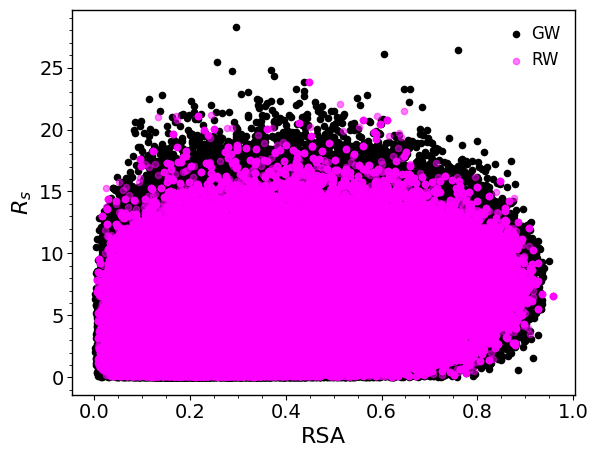

In [19]:
%%time
print("RW_equil MUST be epas 0")
testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
GW_rg = testeq_GW['Rg2']**0.5
GW_rg_mean = GW_rg.mean()
GW_rg_by_rg_mean = GW_rg/GW_rg_mean
testeq_GW['Rg/Rg_mean'] = GW_rg_by_rg_mean

fig,ax = plt.subplots(figsize=(6.5,5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')

ax.scatter(testeq_GW['RSA'],
           testeq_GW['ratio'],s=20,
                color='black',label='GW')

ax.scatter(RW_equil['RSA'],
           RW_equil['ratio'],s=20,alpha=0.5,
                color='magenta',label='RW')

ax.set_xlabel('RSA',fontsize=16 )
ax.set_ylabel('$R_s$',fontsize=16)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)
ax.legend(loc='upper right',fontsize=12,frameon=False,handlelength=0.2)
ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=14, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=14, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)
del testeq_GW


use SELECT ALL to change variables
CPU times: user 40 s, sys: 2.54 s, total: 42.5 s
Wall time: 42.7 s


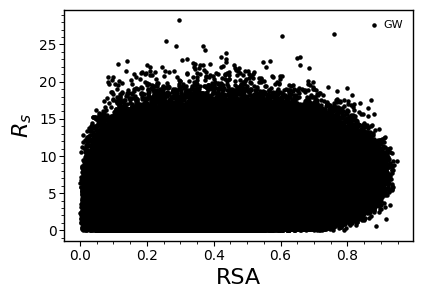

In [21]:
%%time
print('use SELECT ALL to change variables')
testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
GW_rg = testeq_GW['Rg2']**0.5
GW_rg_mean = GW_rg.mean()
GW_rg_by_rg_mean = GW_rg/GW_rg_mean
testeq_GW['Rg/Rg_mean'] = GW_rg_by_rg_mean

fig,ax = plt.subplots(figsize=(4.5,3))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')

ax.scatter(testeq_GW['RSA'],
           testeq_GW['ratio'],s=5,
                color='black',label='GW')

# ax.scatter(SAW_equil[SAW_equil.epas==0]['RSA'],
#            SAW_equil[SAW_equil.epas==0]['ratio'],s=5,alpha=0.5,
#                 color='orange',label='SAW')


# fC_epas_0 = RSA_based_fC(SAW_equil[SAW_equil.epas==0],
#                        'SAW',
#                        'polymer',testeq_GW,
#                        SAW_equil[SAW_equil.epas==0].shape[0],
#                        1,0.1)
# ax.text(0.04,0.9,
#                        r'$f_{C\_shape}$ = '+f"{format(fC_epas_0,'0.3f')}",
#                       transform=ax.transAxes,fontsize=9)
ax.set_xlabel('RSA',fontsize=16 )
ax.set_ylabel('$R_s$',fontsize=16)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)
ax.legend(loc='upper right',fontsize=8,frameon=False,handlelength=0.2)
ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)
del testeq_GW
plt.savefig('figures_for_paper/FOR_PRESENTATION_Rs_RSA_GW.png',format='png',
           dpi=1000,bbox_inches='tight')

use SELECT ALL to change variables
CPU times: user 46 s, sys: 1.9 s, total: 47.9 s
Wall time: 47.8 s


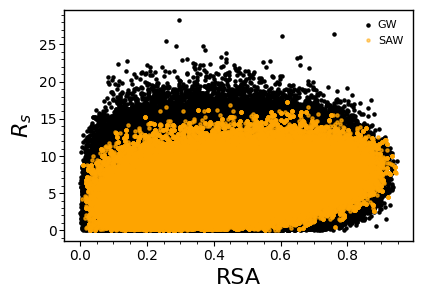

In [22]:
%%time
print('use SELECT ALL to change variables')
testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
GW_rg = testeq_GW['Rg2']**0.5
GW_rg_mean = GW_rg.mean()
GW_rg_by_rg_mean = GW_rg/GW_rg_mean
testeq_GW['Rg/Rg_mean'] = GW_rg_by_rg_mean

fig,ax = plt.subplots(figsize=(4.5,3))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')

ax.scatter(testeq_GW['RSA'],
           testeq_GW['ratio'],s=5,
                color='black',label='GW')

ax.scatter(SAW_equil[SAW_equil.epas==0]['RSA'],
           SAW_equil[SAW_equil.epas==0]['ratio'],s=5,alpha=0.5,
                color='orange',label='SAW')


# fC_epas_0 = RSA_based_fC(SAW_equil[SAW_equil.epas==0],
#                        'SAW',
#                        'polymer',testeq_GW,
#                        SAW_equil[SAW_equil.epas==0].shape[0],
#                        1,0.1)
# ax.text(0.04,0.9,
#                        r'$f_{C\_shape}$ = '+f"{format(fC_epas_0,'0.3f')}",
#                       transform=ax.transAxes,fontsize=9)
ax.set_xlabel('RSA',fontsize=16 )
ax.set_ylabel('$R_s$',fontsize=16)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)
ax.legend(loc='upper right',fontsize=8,frameon=False,handlelength=0.2)
ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)
del testeq_GW
plt.savefig('figures_for_paper/FOR_PRESENTATION_Rs_RSA_GW_SAW_nofCshape.png',format='png',
           dpi=1000,bbox_inches='tight')

use SELECT ALL to change variables
protein_var MUST be single epas
500000 GW snapshots completed
1000000 GW snapshots completed
CPU times: user 1min 10s, sys: 1.13 s, total: 1min 11s
Wall time: 1min 11s


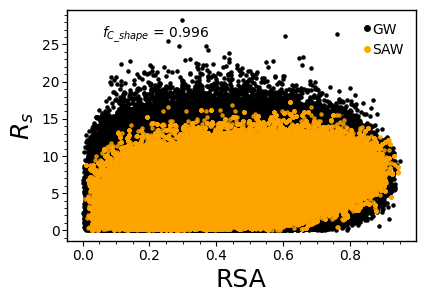

In [30]:
%%time
print('use SELECT ALL to change variables')
testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
GW_rg = testeq_GW['Rg2']**0.5
GW_rg_mean = GW_rg.mean()
GW_rg_by_rg_mean = GW_rg/GW_rg_mean
testeq_GW['Rg/Rg_mean'] = GW_rg_by_rg_mean

fig,ax = plt.subplots(figsize=(4.5,3))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')

ax.scatter(testeq_GW['RSA'],
           testeq_GW['ratio'],s=5,
                color='black',label='GW')

ax.scatter(SAW_equil[SAW_equil.epas==0]['RSA'],
           SAW_equil[SAW_equil.epas==0]['ratio'],s=5,alpha=0.5,
                color='orange',label='SAW')


fC_epas_0 = RSA_based_fC(SAW_equil[SAW_equil.epas==0],
                       'SAW',
                       'polymer',testeq_GW,
                       SAW_equil[SAW_equil.epas==0].shape[0],
                       1,0.1)
ax.text(0.1,0.88,
                       r'$f_{C\_shape}$ = '+f"{format(fC_epas_0,'0.3f')}",
                      transform=ax.transAxes,fontsize=10)
ax.set_xlabel('RSA',fontsize=18 )
ax.set_ylabel('$R_s$',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='GW',
           markerfacecolor='black', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='SAW',
           markerfacecolor='orange', markersize=6),
]

ax.legend(handles=legend_elements,
          loc='upper right',fontsize=10,frameon=False,handlelength=0.1, handletextpad=0.3)
ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)
del testeq_GW
plt.savefig('figures_for_paper/Rs_RSA_GW_SAW.png',format='png',
           dpi=1000,bbox_inches='tight')

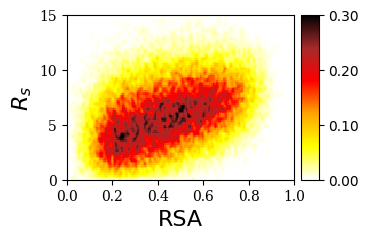

In [22]:
# Define the x and y data 
# For example just using random numbers


x_variable='RSA'
y_variable=r"$R_s$"


x = SAW_equil[SAW_equil.epas==0]['RSA']
y = SAW_equil[SAW_equil.epas==0]['ratio']

 
# Set up default x and y limits
xlims = [0,1]
ylims = [0,15]
 
# Set up your x and y labels
xlabel = x_variable
ylabel = y_variable
 


left, width = 0.12, 0.55
bottom, height = 0.12, 0.55
bottom_h = left_h = left+width

rect_temperature = [left, bottom, width, height] # dimensions of temp plot
#rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
#rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram

 
# Set up the size of the figure
fig = plt.figure(1, figsize=(4.5,3))
 
# Make the three plots
axTemperature = plt.axes(rect_temperature) # temperature plot
#axHistx = plt.axes(rect_histx) # x histogram
#axHisty = plt.axes(rect_histy) # y histogram
 
# Remove the inner axes numbers of the histograms
nullfmt = NullFormatter()
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)
 
# Find the min/max of the data
xmin = min(xlims)
xmax = max(xlims)
ymin = min(ylims)
ymax = max(ylims)
 
# Make the 'main' temperature plot
# Define the number of bins
nxbins = 200
nybins = 100
nbins = nxbins+nybins
 
xbins = linspace(start = xmin, stop = xmax, num = nxbins)
ybins = linspace(start = ymin, stop = ymax, num = nybins)
xcenter = (xbins[0:-1]+xbins[1:])/2.0
ycenter = (ybins[0:-1]+ybins[1:])/2.0
aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)
 
H, xedges,yedges = np.histogram2d(y,x,bins=(ybins,xbins),density=True)
X = xcenter
Y = ycenter
Z = H
 
H = gaussian_filter(H,sigma=1)    
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'yellow',"orange",'red',"brown",'black'])    
# Plot the temperature data
cax = (axTemperature.imshow(H, extent=[xmin,xmax,ymin,ymax],cmap=palette,vmin=0,vmax=0.3,
       interpolation='nearest', origin='lower',aspect=aspectratio))

 
#Plot the axes labels
axTemperature.set_xlabel(xlabel,fontsize=16)
axTemperature.set_ylabel(ylabel,fontsize=16)
 
#Make the tickmarks pretty
ticklabels = axTemperature.get_xticklabels()
for label in ticklabels:
    label.set_fontsize(10)
    label.set_family('serif')
 
ticklabels = axTemperature.get_yticklabels()
for label in ticklabels:
    label.set_fontsize(10)
    label.set_family('serif')
 
#Set up the plot limits
axTemperature.set_xlim(xlims)
axTemperature.set_ylim(ylims)
 
#Set up the histogram bins
xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)
 

def myfmt(x, pos):
    return '{0:.2f}'.format(x)    
    
fig.subplots_adjust(right=0.68)
cbar_ax = fig.add_axes([left+width-0.008, bottom, 0.04, height])
fig.colorbar(cax, cax=cbar_ax,
             format=ticker.FuncFormatter(myfmt))

#Show the plot
plt.draw()

plt.savefig('figures_for_paper/SAW_only_Rs_RSA_heatmap.png',format='png',
           dpi=1000,bbox_inches='tight')